## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import datetime
import random
from pprint import pprint
from tqdm import tqdm

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from ts.data.dataset import SeattleRainfall
from ts.utility import Utility, Metric
from ts.experimental import GeneralizedParetoDistribution, GpdEstimate, Pso
from ts.plot import Plot

## Load Dataset

In [2]:
rainfall_df = pd.read_csv('../datasets/rainfall-data.csv')[['YEAR', 'MN', 'DT', '..R/F']]
rainfall_df

,YEAR,MN,DT,..R/F
0,1970,1,1,0.0
1,1970,1,2,3.2
2,1970,1,3,0.0
3,1970,1,4,0.0
4,1970,1,5,0.0
...,...,...,...,...
17647,2018,4,26,0.0
17648,2018,4,27,2.1
17649,2018,4,28,0.0
17650,2018,4,29,0.0


### Get Rainfall Series

In [3]:
rainfall_series = rainfall_df['..R/F'].to_numpy()
n = rainfall_series.shape[0]

print(f'Rainfall data: datatype: {rainfall_series.dtype}, '
    + f'shape: {rainfall_series.shape}, '
    + f'Contains NaN: {np.isnan(rainfall_series).any()}')

Rainfall data: datatype: float64, shape: (17652,), Contains NaN: False


In [4]:
date_series = [0] * len(rainfall_df)

for index, row in rainfall_df.iterrows():
    date_series[index] = datetime.date(int(row['YEAR']), int(row['MN']), int(row['DT']))

## Train-Test Split

In [5]:
train_frac = 0.90
num_train = int(n * train_frac)

print(f'Length of training series: {num_train}, '
     + f'Length of test series: {n - num_train}')

Length of training series: 15886, Length of test series: 1766


### Plot Entire Data

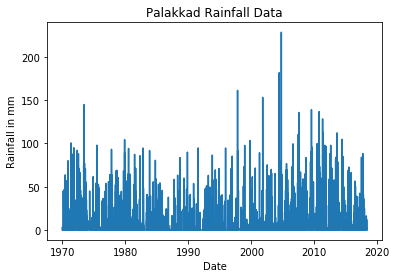

In [6]:
plt.plot(date_series, rainfall_df['..R/F'].to_numpy())
plt.title('Palakkad Rainfall Data')
plt.xlabel('Date')
plt.ylabel('Rainfall in mm')
plt.show()

### All Data Histogram

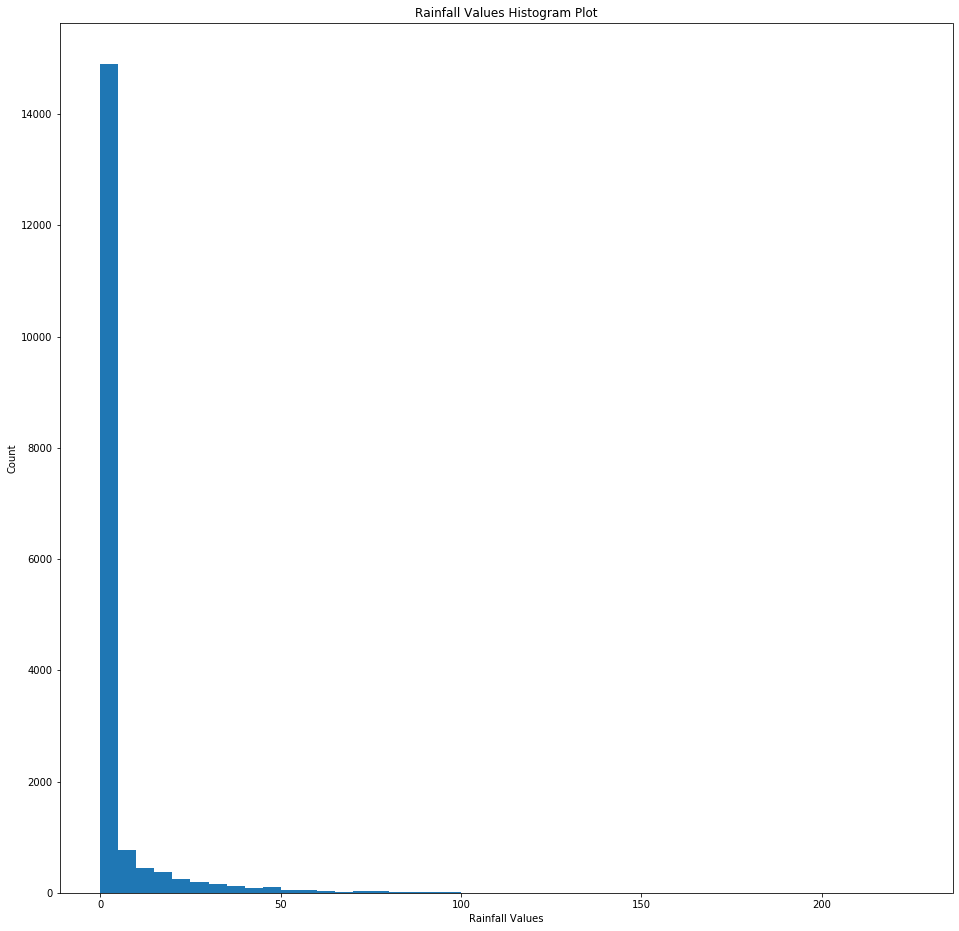

In [7]:
bin_width = 5
bins = np.arange(
    rainfall_series.min(), rainfall_series.max() + 1, 
    bin_width
)

plt.figure(figsize=(16, 16))
plt.hist(rainfall_series, bins)
plt.xlabel('Rainfall Values')
plt.ylabel('Count')
plt.title('Rainfall Values Histogram Plot')
plt.show()

### Data histogram of values above a lower bound

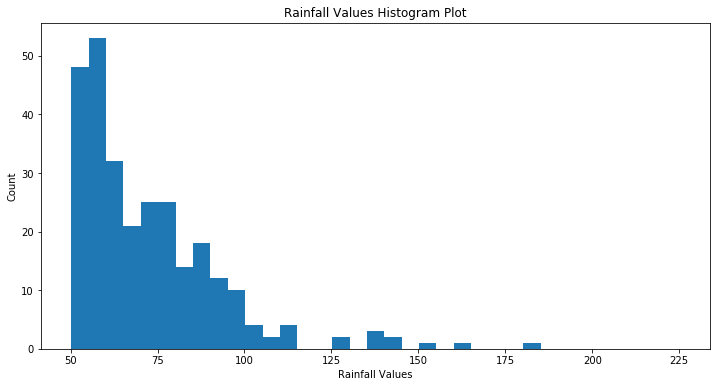

In [8]:
lower_bound = 50

bounded_rainfall_series = \
    rainfall_series[rainfall_series > lower_bound]

bin_width = 5
bins = np.arange(
    bounded_rainfall_series.min(), 
    bounded_rainfall_series.max() + 1, 
    bin_width
)

plt.figure(figsize=(12, 6))
plt.hist(bounded_rainfall_series, bins)
plt.xlabel('Rainfall Values')
plt.ylabel('Count')
plt.title('Rainfall Values Histogram Plot')
plt.show()

### Complementary Cumulative Data of values above a lower bound

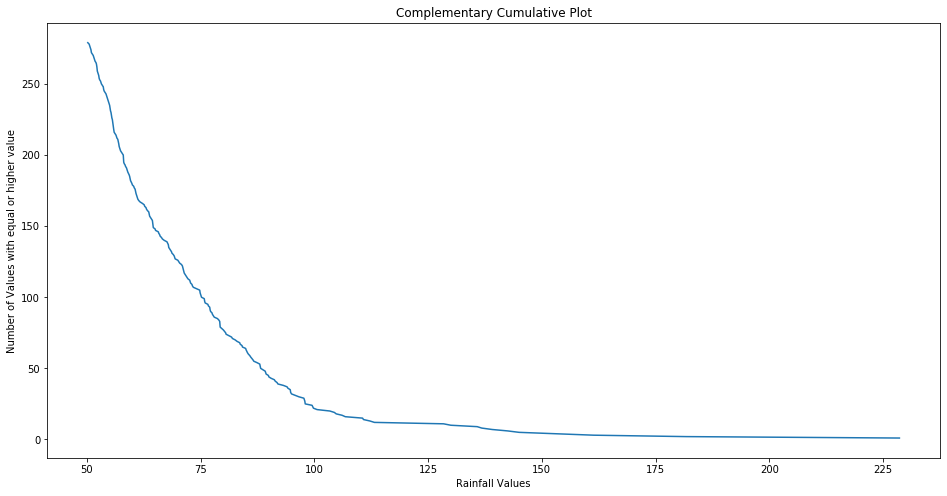

In [9]:
lower_bound = 50

bounded_count = dict()

for rain_value in rainfall_series:
    
    if rain_value <= lower_bound:
        continue
    
    if rain_value not in bounded_count:
        bounded_count[rain_value] = 1
    else:
        bounded_count[rain_value] += 1
        
rainfall_count = list(bounded_count.items())
rainfall_count.sort(key=lambda rain_count: rain_count[0])
rainfall_arr, count_arr = list(zip(*rainfall_count))
count_cusum_rev = [0] * len(count_arr)

count_cusum_rev[-1] = count_arr[-1]
for i in range(len(count_cusum_rev) - 2, -1, -1):
    count_cusum_rev[i] = count_cusum_rev[i + 1] + count_arr[i]

plt.figure(figsize=(16, 8))
plt.plot(rainfall_arr, count_cusum_rev)
plt.xlabel('Rainfall Values')
plt.ylabel('Number of Values with equal or higher value')
plt.title('Complementary Cumulative Plot')
plt.show()

## Computing Threshold Exceedances

In [10]:
threshold = 50 # Rainfall in mm

exceed_series = []

for i in range(num_train):
    
    if rainfall_series[i] > threshold:
        exceed_series.append(rainfall_series[i] - threshold)
        
exceed_series = np.array(exceed_series)

print(f'Exceedances Series: datatype: {exceed_series.dtype}, '
    + f'shape: {exceed_series.shape}')

Exceedances Series: datatype: float64, shape: (247,)


# Parameter Estimation of GEV fitted to Remainder Series

Shape Parameter: 0.004373062921814399 
Scale Parameter: 23.345168503296964 
Log Likelihood: -1026.226494703308


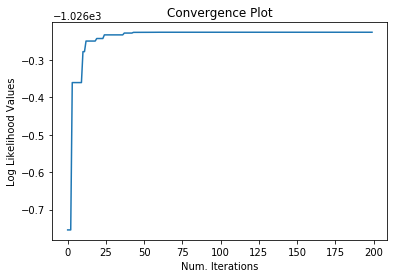

In [11]:
params, max_log_likelihood, max_log_likelihood_vals = GpdEstimate.psoMethod(
    exceed_series,
    Pso.computeInitialPos([(-10, 10), (5, 30)], 250),
    numIterations=200
)

shape, scale = params
print(f'Shape Parameter: {shape} \n'
    + f'Scale Parameter: {scale} \n'
    + f'Log Likelihood: {max_log_likelihood}')

plt.plot(max_log_likelihood_vals)
plt.title('Convergence Plot')
plt.xlabel('Num. Iterations')
plt.ylabel('Log Likelihood Values')
plt.show()

In [12]:
gpd_dist = GeneralizedParetoDistribution(*tuple(params))

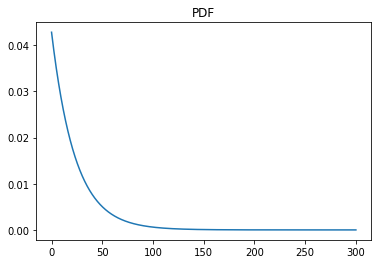

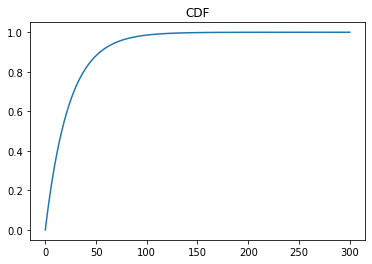

In [13]:
x = np.linspace(0, 300, 10000)

plt.plot(x, gpd_dist.pdf(x))
plt.title('PDF')
plt.show()

plt.plot(x, gpd_dist.cdf(x))
plt.title('CDF')
plt.show()

# Algorithm

## Part 1: Extreme Value CDF Prediction Algorithm

### Build Model Architecture

In [14]:
lag = 50

model_extreme = Sequential([
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model_extreme.build(input_shape=(None, lag))
model_extreme.compile(
    optimizer=Adam(
        ExponentialDecay(
            0.02, 50, 0.9
        )
    ),
    loss=tf.losses.MeanSquaredError()
)

### Build Training Data

In [15]:
input_data = []
output_data = []

for i in range(lag, num_train):
    
    if rainfall_series[i] > threshold:
        input_data.append(rainfall_series[i - lag: i])
        
        exceedance = rainfall_series[i] - threshold
        output_data.append(gpd_dist.cdf(exceedance))

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Data: datatype: {output_data.dtype}, shape: {output_data.shape}')

Input Data: datatype: float64, shape: (247, 50)
Output Data: datatype: float64, shape: (247, 1)


In [16]:
# First Few Data Points
first_few = 5

print('First few inputs:')
pprint(input_data[:first_few])
print()

print(f'First few outputs:')
pprint(output_data[:first_few])
print()

# Last Few Data Points
last_few = 5

print('Last few inputs:')
pprint(input_data[-first_few:])
print()

print(f'Last few outputs:')
pprint(output_data[-first_few:])
print()

First few inputs:
array([[ 0. ,  0. ,  0. ,  0. , 47. ,  5. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        18. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  2.6,  1.6,  3. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  1.6,  0. , 10.6,  0. ,  0. , 25.2,
         0. ,  0. , 16.6,  5. , 14. , 14.2,  8.8,  2.6, 13. ,  1.2,  0. ,
         0. , 22.6, 33.6,  8.6, 18.6, 32.6],
       [ 0. ,  0. ,  3. ,  5.2, 11. ,  5. ,  2. ,  0. ,  0.8, 39. , 31.4,
        30.4, 15.2, 21. ,  2.8,  2. ,  0. ,  7.6,  6.2, 31. ,  9. , 19. ,
        12.8, 17. ,  0. ,  0. ,  2. , 20. ,  5. ,  2.6, 36. ,  1. , 25. ,
        16. ,  7. , 15. , 10. , 26. , 20. , 25.2, 12.2, 41.6,  6. ,  2. ,
         0. , 40. ,  0. , 38.8, 19. ,  9.6],
       [ 0. ,  3. ,  5.2, 11. ,  5. ,  2. ,  0. ,  0.8, 39. , 31.4, 30.4,
        15.2, 21. ,  2.8,  2. ,  0. ,  7.6,  6.2, 31. ,  9. , 19. , 12.8,
        17. ,  0. ,  0. ,  2. , 20. ,  5. ,  2.6, 36. ,  1. , 25. , 16. ,
         7. , 15. , 10. , 26. , 20. , 25.2, 12.2, 41.6,  6. ,  2. ,  0. ,
    

### Train the Model

Epoch 1/100
8/8 [==============================] - 0s 1ms/step - loss: 0.1386
Epoch 2/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0891
Epoch 3/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0792
Epoch 4/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0753
Epoch 5/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0715
Epoch 6/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0659
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0605
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0543
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0475
Epoch 10/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0422
Epoch 11/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0392
Epoch 12/100
8/8 [==============================] - 0s 1ms/step - loss: 0.0380
Epoch 13/100
8/8 [==============================] - 0s 2ms/st

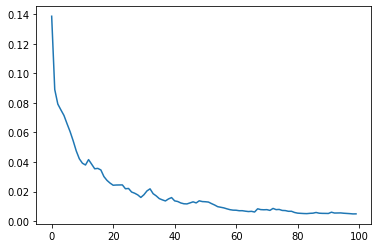

In [17]:
history = model_extreme.fit(input_data, output_data, epochs=100)
plt.plot(history.history['loss'])

### Compute Test Loss

In [18]:
input_data = []
output_data = []
output_actual = []

for i in range(max(num_train, lag), n):
    
    if rainfall_series[i] > threshold:
        input_data.append(rainfall_series[i - lag: i])
        
        exceedance = rainfall_series[i] - threshold
        output_data.append(gpd_dist.cdf(exceedance))
        
        output_actual.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)
output_actual = np.expand_dims(np.array(output_actual), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

true_val = output_data
pred_val = model_extreme.predict(input_data)
pred_actual = threshold + gpd_dist.computeQuantile(pred_val)

test_loss_cdf = MeanSquaredError()(true_val, pred_val)
print(f'Test Loss (CDF): {test_loss_cdf}')

test_loss = MeanSquaredError()(output_actual, pred_actual)
print(f'Test Loss (Actual): {test_loss}')

Input Test Data: datatype: float64, shape: (32, 50)
Output Test Data: datatype: float64, shape: (32, 1)

Test Loss (CDF): 0.11228770762681961
Test Loss (Actual): 405.2292785644531


## Part 2: Extreme Value Detection (Classification) Algorithm

In [19]:
class MlpEnsemble:
    
    def get_model(self, lag):
        
        model = Sequential([
            Dense(16, activation='relu'),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(1, activation='linear')
        ])
        
        model.build(input_shape=(None, lag))
        model.compile(
            optimizer=Adam(
                ExponentialDecay(
                    1e-3, 50, 0.9
                )
            ),
            loss=BinaryCrossentropy(from_logits=True)
        )
        
        return model
    
    def __init__(self, lag, num_models=10, neg_data_ratio=1.0):
        
        self.models = [self.get_model(lag) for _ in range(num_models)]
        self.neg_data_ratio = neg_data_ratio
        
    def train(self, input_data, output_data, each_model_epochs):
        
        pos_data = []
        neg_data = []
        
        for i in range(input_data.shape[0]):
            
            if output_data[i, 0] == 1:
                pos_data.append((input_data[i], output_data[i]))
                
            else:
                neg_data.append((input_data[i], output_data[i]))
        
        assert len(pos_data) < len(neg_data)
        
        losses = np.zeros(each_model_epochs)
        num_neg_to_take = int(len(pos_data) * self.neg_data_ratio)
        
        for model in self.models:
            
            data = pos_data.copy()
            data.extend(random.sample(neg_data, k=num_neg_to_take))
            
            input_data, output_data = [], []
            for inp, out in data:
                input_data.append(inp)
                output_data.append(out)
                
            input_data = np.array(input_data)
            output_data = np.array(output_data)
        
            history = model.fit(
                input_data, 
                output_data, 
                epochs=each_model_epochs,
                verbose=0
            )
            
            losses += np.array(history.history['loss'])
                
        losses /= len(self.models)
        return losses
    
    def predict(self, input_data):
        
        num_pos = np.zeros((input_data.shape[0], 1), dtype=np.int64)
        num_neg = np.zeros((input_data.shape[0], 1), dtype=np.int64)
        
        for model in self.models:
            
            model_out = model.predict(input_data)
            model_pred = (tf.sigmoid(model_out).numpy() > 0.5) \
                .astype(np.int64)
            
            num_pos += model_pred
            num_neg += (1 - model_pred)
            
        pred = (num_pos > num_neg).astype(np.int64)
        return pred

In [20]:
model_detect = MlpEnsemble(lag=lag, num_models=10, neg_data_ratio=1.5)

### Build Training Data

In [21]:
input_data = []
output_data = []

for i in range(lag, num_train):
    
    input_data.append(rainfall_series[i - lag: i])
    
    if rainfall_series[i] > threshold:
        output_data.append(1)
    
    else:
        output_data.append(0)

        
input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Data: datatype: {output_data.dtype}, shape: {output_data.shape}')

Input Data: datatype: float64, shape: (15836, 50)
Output Data: datatype: int64, shape: (15836, 1)


In [22]:
# First Few Data Points
first_few = 5

print('First few inputs:')
pprint(input_data[:first_few])
print()

print(f'First few outputs:')
pprint(output_data[:first_few])
print()

# Last Few Data Points
last_few = 5

print('Last few inputs:')
pprint(input_data[-first_few:])
print()

print(f'Last few outputs:')
pprint(output_data[-first_few:])
print()

First few inputs:
array([[ 0. ,  3.2,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 3.2,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. , 45. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
    

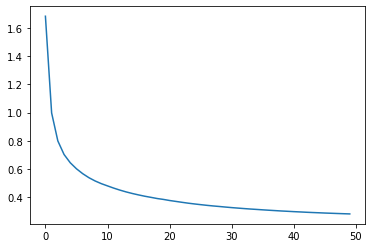

In [23]:
losses = model_detect.train(input_data, output_data, 50)
plt.plot(losses)

In [24]:
is_pos = output_data == 1.

num_true_pos = np.sum(model_detect.predict(input_data)[is_pos])
total_pos = np.sum(is_pos)

is_neg = np.logical_not(is_pos)
num_true_neg = np.sum(1 - model_detect.predict(input_data)[is_neg])
total_neg = np.sum(is_neg)

print(f'Train: True Pos: {num_true_pos}, Total Pos: {total_pos}')
print(f'Train: True Neg: {num_true_neg}, Total Neg: {total_neg}')

Train: True Pos: 210, Total Pos: 247
Train: True Neg: 13793, Total Neg: 15589


## Part 3: Normal Value Prediction Algorithm

In [25]:
model_normal = Sequential([
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear'),
])    
    
model_normal.build(input_shape=(None, lag))
model_normal.compile(
    optimizer=Adam(
        ExponentialDecay(
            0.01, 50, 0.9
        )
    ),
    loss=MeanSquaredError()
)

### Build Training Data

In [26]:
input_data = []
output_data = []

for i in range(lag, num_train):
    
    if rainfall_series[i] <= threshold:
        input_data.append(rainfall_series[i - lag: i])
        output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Data: datatype: {output_data.dtype}, shape: {output_data.shape}')

Input Data: datatype: float64, shape: (15589, 50)
Output Data: datatype: float64, shape: (15589, 1)


In [27]:
# First Few Data Points
first_few = 5

print('First few inputs:')
pprint(input_data[:first_few])
print()

print(f'First few outputs:')
pprint(output_data[:first_few])
print()

# Last Few Data Points
last_few = 5

print('Last few inputs:')
pprint(input_data[-first_few:])
print()

print(f'Last few outputs:')
pprint(output_data[-first_few:])
print()

First few inputs:
array([[ 0. ,  3.2,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 3.2,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. , 45. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
    

Epoch 1/20
488/488 [==============================] - 1s 1ms/step - loss: 49.3173
Epoch 2/20
488/488 [==============================] - 0s 867us/step - loss: 46.0746
Epoch 3/20
488/488 [==============================] - 0s 718us/step - loss: 44.8971
Epoch 4/20
488/488 [==============================] - 0s 727us/step - loss: 44.3850
Epoch 5/20
488/488 [==============================] - 0s 733us/step - loss: 44.1657
Epoch 6/20
488/488 [==============================] - 0s 725us/step - loss: 44.0915
Epoch 7/20
488/488 [==============================] - 0s 727us/step - loss: 44.0548
Epoch 8/20
488/488 [==============================] - 0s 721us/step - loss: 44.0436
Epoch 9/20
488/488 [==============================] - 0s 734us/step - loss: 44.0391
Epoch 10/20
488/488 [==============================] - 0s 734us/step - loss: 44.0374
Epoch 11/20
488/488 [==============================] - 0s 818us/step - loss: 44.0368
Epoch 12/20
488/488 [==============================] - 0s 698us/step - loss:

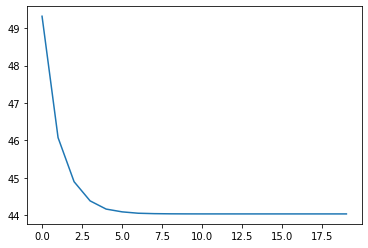

In [28]:
history = model_normal.fit(input_data, output_data, epochs=20)
plt.plot(history.history['loss'])

## Compute Test Loss

In [29]:
input_data = []
output_data = []
output_actual = []

for i in range(max(num_train, lag), n):
    
    if rainfall_series[i] <= threshold:
        input_data.append(rainfall_series[i - lag: i])
        output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

true_val = output_data
pred_val = model_extreme.predict(input_data)

test_loss_cdf = MeanSquaredError()(true_val, pred_val)
print(f'Test Loss: {test_loss_cdf}')

Input Test Data: datatype: float64, shape: (1734, 50)
Output Test Data: datatype: float64, shape: (1734, 1)

Test Loss: 85.24901580810547


# Combining Algorithms

## Forecasting Training Data

In [30]:
input_data = []
output_data = []

for i in range(lag, num_train):

    input_data.append(rainfall_series[i - lag: i])
    output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

Input Test Data: datatype: float64, shape: (15836, 50)
Output Test Data: datatype: float64, shape: (15836, 1)



In [31]:
is_extreme = model_detect.predict(input_data)

pred_extreme = gpd_dist.computeQuantile(model_extreme.predict(input_data)) \
            + threshold

pred_normal = model_normal.predict(input_data)

pred_outputs = np.zeros(output_data.shape)

for i in range(pred_outputs.shape[0]):
    if is_extreme[i, 0]:
        pred_outputs[i] = pred_extreme[i]
    else:
        pred_outputs[i] = pred_normal[i]
        
is_extreme = np.squeeze(is_extreme, axis=1)
pred_extreme = np.squeeze(pred_extreme, axis=1)
pred_normal = np.squeeze(pred_normal, axis=1)
pred_outputs = np.squeeze(pred_outputs, axis=1)
output_data = np.squeeze(output_data, axis=1)

/Users/ahmed/Programming/Project/Forecast/ts/experimental/genpareto.py:44: RuntimeWarning: divide by zero encountered in power
  return self.scaleParam * ((1 - p) ** (-self.shapeParam) - 1) / self.shapeParam


In [32]:
print(pred_extreme.shape, output_data.shape)

(15836,) (15836,)


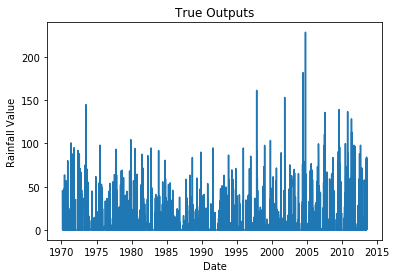

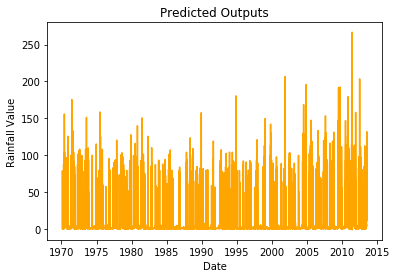

In [33]:
plt.plot(date_series[lag: num_train], output_data)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('True Outputs')
plt.show()

plt.plot(date_series[lag: num_train], pred_outputs, color='orange')
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('Predicted Outputs')
plt.show()

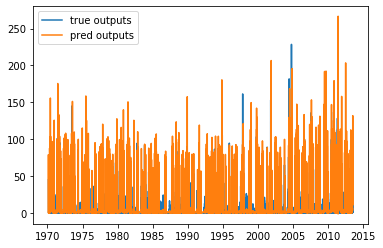

In [34]:
plt.plot(date_series[lag: num_train], output_data, label='true outputs')
plt.plot(date_series[lag: num_train], pred_outputs, label='pred outputs')
plt.legend()
plt.show()

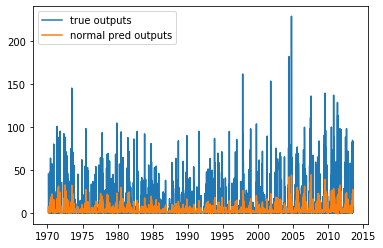

In [35]:
plt.plot(date_series[lag: num_train], output_data, label='true outputs')
plt.plot(date_series[lag: num_train], pred_normal, label='normal pred outputs')
plt.legend()
plt.show()

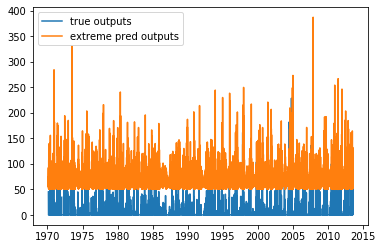

In [36]:
plt.plot(date_series[lag: num_train], output_data, label='true outputs')
plt.plot(date_series[lag: num_train], pred_extreme, label='extreme pred outputs')
plt.legend()
plt.show()

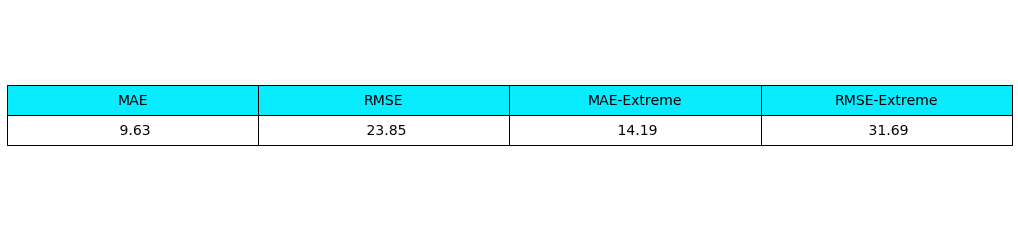

In [42]:
Plot.plotTable(
    ['MAE', 'RMSE', 'MAE-Extreme', 'RMSE-Extreme'],
    'top',
    np.array([[
        Metric.mae(pred_outputs, output_data), 
        Metric.rmse(pred_outputs, output_data),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.mae),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.rmse)
    ]])
)

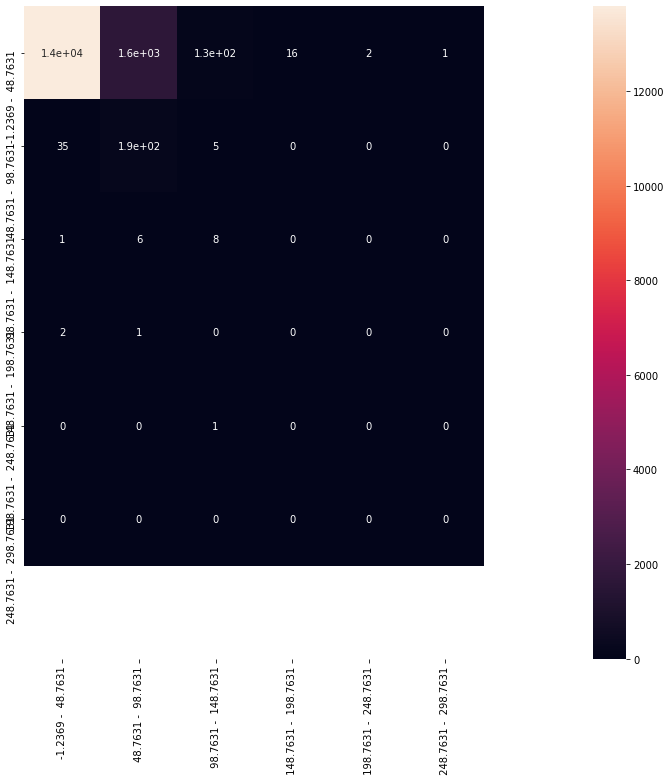

In [43]:
Plot.plotConfusionMatrix(output_data, pred_outputs, 50., 4)

## Forecasting Test Data

In [44]:
input_data = []
output_data = []

for i in range(max(num_train, lag), n):

    input_data.append(rainfall_series[i - lag: i])
    output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

Input Test Data: datatype: float64, shape: (1766, 50)
Output Test Data: datatype: float64, shape: (1766, 1)



In [45]:
is_extreme = model_detect.predict(input_data)

pred_extreme = gpd_dist.computeQuantile(model_extreme.predict(input_data)) \
            + threshold

pred_normal = model_normal.predict(input_data)

pred_outputs = np.zeros(output_data.shape)

for i in range(pred_outputs.shape[0]):
    if is_extreme[i, 0]:
        pred_outputs[i] = pred_extreme[i]
    else:
        pred_outputs[i] = pred_normal[i]
        
is_extreme = np.squeeze(is_extreme, axis=1)
pred_extreme = np.squeeze(pred_extreme, axis=1)
pred_normal = np.squeeze(pred_normal, axis=1)
pred_outputs = np.squeeze(pred_outputs, axis=1)
output_data = np.squeeze(output_data, axis=1)

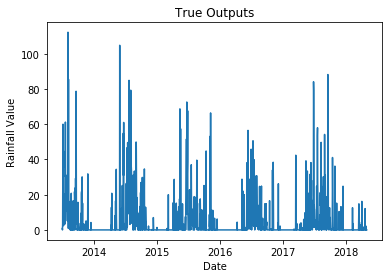

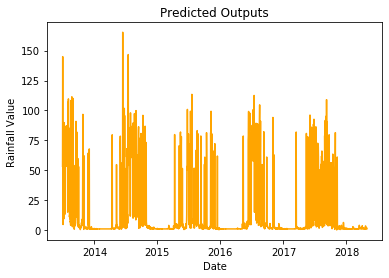

In [46]:
plt.plot(date_series[num_train:], output_data)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('True Outputs')
plt.show()

plt.plot(date_series[num_train:], pred_outputs, color='orange')
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('Predicted Outputs')
plt.show()

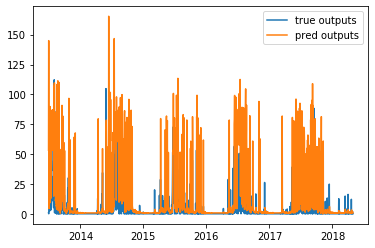

In [47]:
plt.plot(date_series[num_train:], output_data, label='true outputs')
plt.plot(date_series[num_train:], pred_outputs, label='pred outputs')
plt.legend()
plt.show()

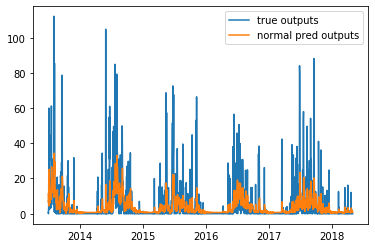

In [48]:
plt.plot(date_series[num_train:], output_data, label='true outputs')
plt.plot(date_series[num_train:], pred_normal, label='normal pred outputs')
plt.legend()
plt.show()

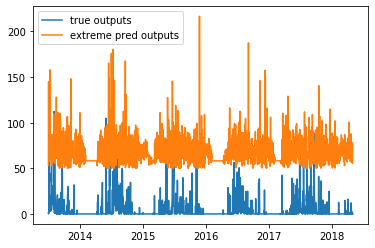

In [49]:
plt.plot(date_series[num_train:], output_data, label='true outputs')
plt.plot(date_series[num_train:], pred_extreme, label='extreme pred outputs')
plt.legend()
plt.show()

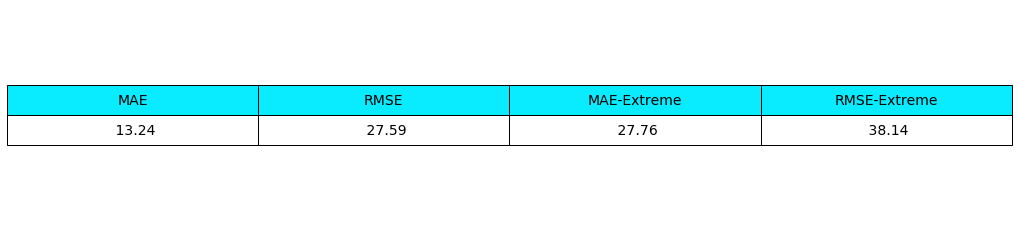

In [50]:
Plot.plotTable(
    ['MAE', 'RMSE', 'MAE-Extreme', 'RMSE-Extreme'],
    'top',
    np.array([[
        Metric.mae(pred_outputs, output_data), 
        Metric.rmse(pred_outputs, output_data),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.mae),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.rmse)
    ]])
)

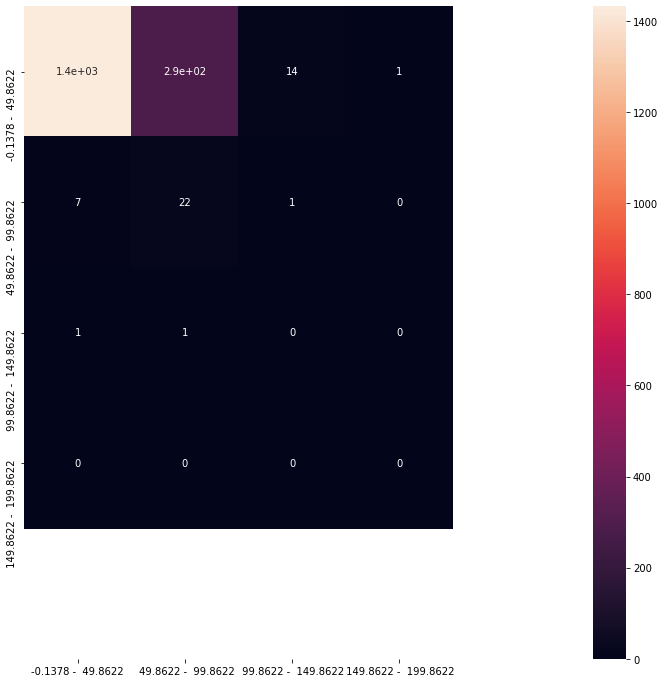

In [51]:
Plot.plotConfusionMatrix(output_data, pred_outputs, 50, 4)

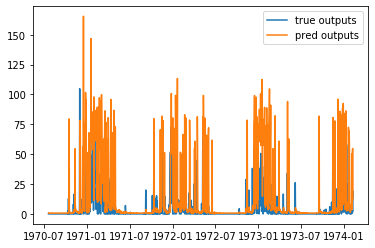

In [52]:
start_idx = 200
end_idx = 1500

plt.plot(date_series[start_idx: end_idx], output_data[start_idx: end_idx], label='true outputs')
plt.plot(date_series[start_idx: end_idx], pred_outputs[start_idx: end_idx], label='pred outputs')
plt.legend()
plt.show()

# MLP

In [53]:
lag_mlp = 50

mlp_model = Sequential([
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear'),
])    
    
mlp_model.build(input_shape=(None, lag))
mlp_model.compile(
    optimizer=Adam(
        ExponentialDecay(
            0.01, 50, 0.9
        )
    ),
    loss=MeanSquaredError()
)

## Train the Model

In [67]:
input_data = []
output_data = []

for i in range(lag_mlp, num_train):

    input_data.append(rainfall_series[i - lag: i])
    output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

Input Test Data: datatype: float64, shape: (15836, 50)
Output Test Data: datatype: float64, shape: (15836, 1)



Epoch 1/100
495/495 [==============================] - 0s 744us/step - loss: 121.4278
Epoch 2/100
495/495 [==============================] - 0s 733us/step - loss: 111.6985
Epoch 3/100
495/495 [==============================] - 0s 752us/step - loss: 108.5373
Epoch 4/100
495/495 [==============================] - 0s 743us/step - loss: 107.0949
Epoch 5/100
495/495 [==============================] - 1s 1ms/step - loss: 106.4892
Epoch 6/100
495/495 [==============================] - 0s 765us/step - loss: 106.2108
Epoch 7/100
495/495 [==============================] - 0s 826us/step - loss: 106.1188
Epoch 8/100
495/495 [==============================] - 0s 762us/step - loss: 106.0747
Epoch 9/100
495/495 [==============================] - 0s 773us/step - loss: 106.0608
Epoch 10/100
495/495 [==============================] - 0s 769us/step - loss: 106.0563
Epoch 11/100
495/495 [==============================] - 0s 806us/step - loss: 106.0547
Epoch 12/100
495/495 [==============================] 

Epoch 96/100
495/495 [==============================] - 0s 787us/step - loss: 106.0538
Epoch 97/100
495/495 [==============================] - 0s 797us/step - loss: 106.0539
Epoch 98/100
495/495 [==============================] - 0s 719us/step - loss: 106.0539
Epoch 99/100
495/495 [==============================] - 0s 698us/step - loss: 106.0539
Epoch 100/100
495/495 [==============================] - 0s 710us/step - loss: 106.0539


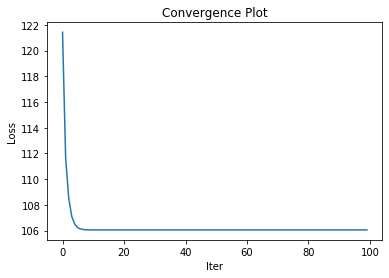

In [55]:
history = mlp_model.fit(input_data, output_data, epochs=100)

plt.plot(history.history['loss'])
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.title('Convergence Plot')
plt.show()

## Forecast Training Data

In [68]:
pred_outputs = mlp_model.predict(input_data)

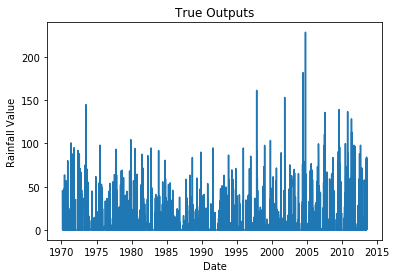

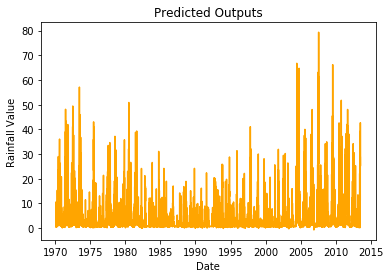

In [69]:
plt.plot(date_series[lag: num_train], output_data)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('True Outputs')
plt.show()

plt.plot(date_series[lag: num_train], pred_outputs, color='orange')
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('Predicted Outputs')
plt.show()

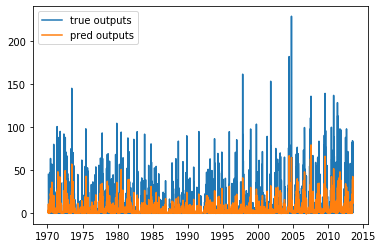

In [70]:
plt.plot(date_series[lag: num_train], output_data, label='true outputs')
plt.plot(date_series[lag: num_train], pred_outputs, label='pred outputs')
plt.legend()
plt.show()

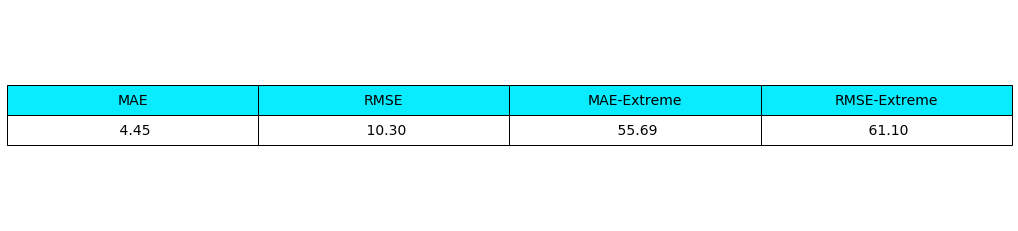

In [71]:
Plot.plotTable(
    ['MAE', 'RMSE', 'MAE-Extreme', 'RMSE-Extreme'],
    'top',
    np.array([[
        Metric.mae(pred_outputs, output_data), 
        Metric.rmse(pred_outputs, output_data),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.mae),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.rmse)
    ]])
)

## Forecast Test Data

In [72]:
input_data = []
output_data = []

for i in range(num_train, n):

    input_data.append(rainfall_series[i - lag: i])
    output_data.append(rainfall_series[i])

input_data = np.array(input_data)
output_data = np.expand_dims(np.array(output_data), axis=1)

print(f'Input Test Data: datatype: {input_data.dtype}, shape: {input_data.shape}')
print(f'Output Test Data: datatype: {output_data.dtype}, shape: {output_data.shape}')
print('')

pred_outputs = mlp_model.predict(input_data)

Input Test Data: datatype: float64, shape: (1766, 50)
Output Test Data: datatype: float64, shape: (1766, 1)



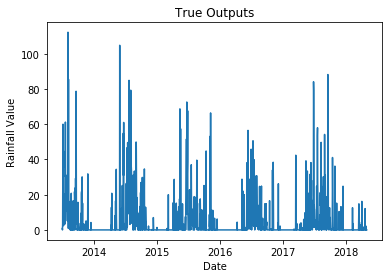

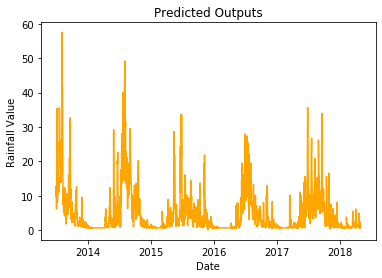

In [73]:
plt.plot(date_series[num_train:], output_data)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('True Outputs')
plt.show()

plt.plot(date_series[num_train:], pred_outputs, color='orange')
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('Predicted Outputs')
plt.show()

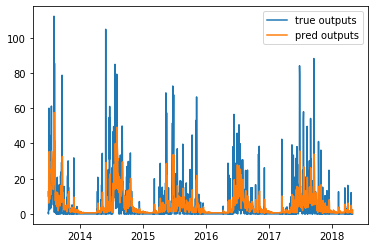

In [74]:
plt.plot(date_series[num_train:], output_data, label='true outputs')
plt.plot(date_series[num_train:], pred_outputs, label='pred outputs')
plt.legend()
plt.show()

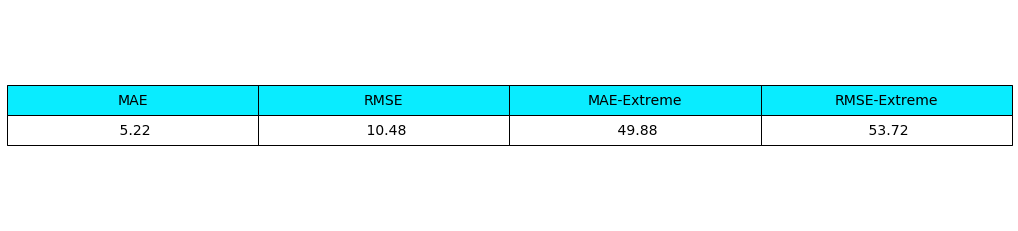

In [75]:
Plot.plotTable(
    ['MAE', 'RMSE', 'MAE-Extreme', 'RMSE-Extreme'],
    'top',
    np.array([[
        Metric.mae(pred_outputs, output_data), 
        Metric.rmse(pred_outputs, output_data),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.mae),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.rmse)
    ]])
)

# Extreme Time 1

In [76]:
from ts.model import ExtremeTime

model = ExtremeTime(
    forecastHorizon=1,
    memorySize=30,
    windowSize=20,
    encoderStateSize=10,
    lstmStateSize=10,
    numExoVariables=0
)

## Training

begin iteration 0
Completed Iteration: 0 | time taken:  83.93 sec | Avg Iteration Loss: 134.26107134627867
begin iteration 1
Completed Iteration: 1 | time taken:  79.58 sec | Avg Iteration Loss: 133.78957787919865
begin iteration 2
Completed Iteration: 2 | time taken:  70.19 sec | Avg Iteration Loss: 129.98652202043877
begin iteration 3
Completed Iteration: 3 | time taken:  69.20 sec | Avg Iteration Loss: 127.49054523087042
begin iteration 4
Completed Iteration: 4 | time taken:  67.90 sec | Avg Iteration Loss: 125.14843091496758
begin iteration 5
Completed Iteration: 5 | time taken:  69.91 sec | Avg Iteration Loss: 127.8319900287152
begin iteration 6
Completed Iteration: 6 | time taken:  78.75 sec | Avg Iteration Loss: 127.83899476945167
begin iteration 7
Completed Iteration: 7 | time taken:  79.52 sec | Avg Iteration Loss: 124.28348348284193
begin iteration 8
Completed Iteration: 8 | time taken:  79.53 sec | Avg Iteration Loss: 120.59948536973194
begin iteration 9
Completed Iteration:

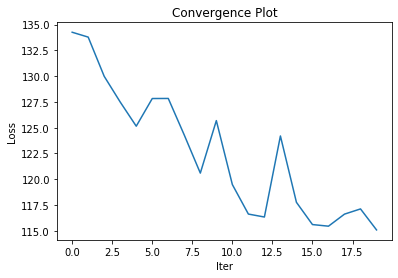

In [79]:
losses = model.train(
    targetSeries=rainfall_series[:num_train], 
    sequenceLength=500,
    numIterations=20,
    optimizer=Adam(
        ExponentialDecay(
            0.01, 50, 0.9
        )
    )
)

plt.plot(losses)
plt.title('Convergence Plot')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.show()

## Forecasting Training Data

In [89]:
output_data = rainfall_series[1: num_train]
pred_outputs = model.predict(rainfall_series[:num_train - 1])

print(pred_outputs.shape, output_data.shape)

(15885,) (15885,)


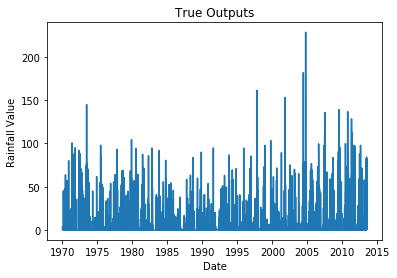

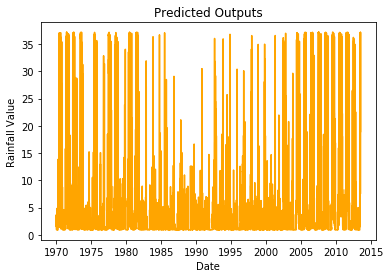

In [90]:
plt.plot(date_series[1: num_train], output_data)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('True Outputs')
plt.show()

plt.plot(date_series[1: num_train], pred_outputs, color='orange')
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('Predicted Outputs')
plt.show()

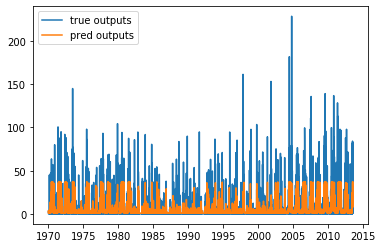

In [91]:
plt.plot(date_series[1: num_train], output_data, label='true outputs')
plt.plot(date_series[1: num_train], pred_outputs, label='pred outputs')
plt.legend()
plt.show()

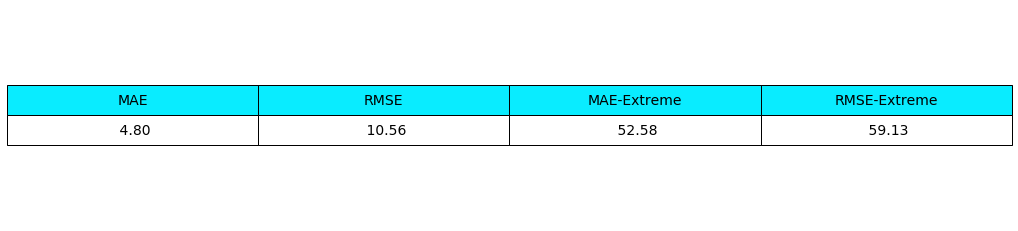

In [92]:
Plot.plotTable(
    ['MAE', 'RMSE', 'MAE-Extreme', 'RMSE-Extreme'],
    'top',
    np.array([[
        Metric.mae(pred_outputs, output_data), 
        Metric.rmse(pred_outputs, output_data),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.mae),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.rmse)
    ]])
)

## Forecasting Test Data

In [96]:
output_data = rainfall_series[num_train + 1:]
pred_outputs = model.predict(rainfall_series[num_train: n - 1])

print(pred_outputs.shape, output_data.shape)

(1765,) (1765,)


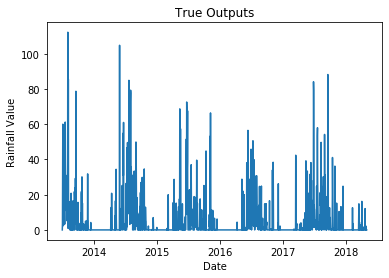

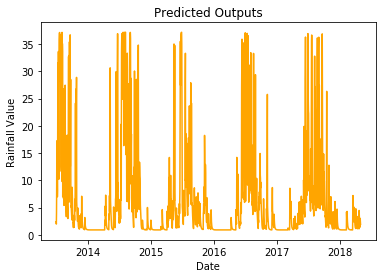

In [97]:
plt.plot(date_series[num_train + 1:], output_data)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('True Outputs')
plt.show()

plt.plot(date_series[num_train + 1:], pred_outputs, color='orange')
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('Predicted Outputs')
plt.show()

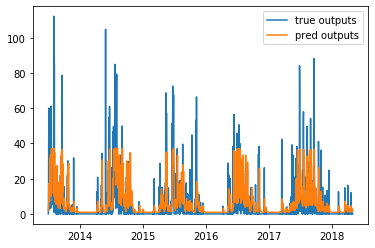

In [98]:
plt.plot(date_series[num_train + 1:], output_data, label='true outputs')
plt.plot(date_series[num_train + 1:], pred_outputs, label='pred outputs')
plt.legend()
plt.show()

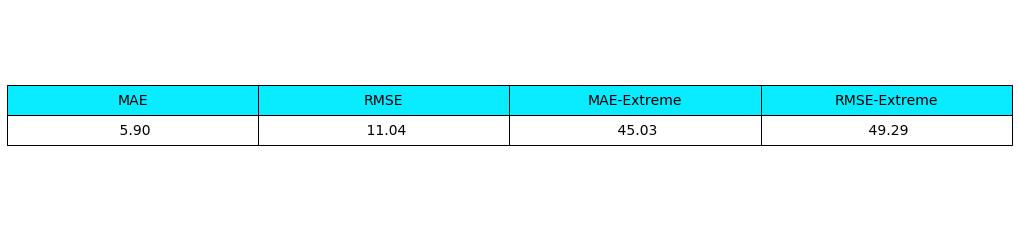

In [99]:
Plot.plotTable(
    ['MAE', 'RMSE', 'MAE-Extreme', 'RMSE-Extreme'],
    'top',
    np.array([[
        Metric.mae(pred_outputs, output_data), 
        Metric.rmse(pred_outputs, output_data),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.mae),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.rmse)
    ]])
)

# Extreme Time 2

In [106]:
from ts.model import ExtremeTime2

model = ExtremeTime2(
    forecastHorizon=1,
    memorySize=30,
    windowSize=30,
    embeddingSize=10,
    contextSize=10,
    numExoVariables=0
)

begin iteration 0
Completed Iteration: 0 | time taken:  122.34 sec | Avg Iteration Loss: 149.5375694484864
begin iteration 1
Completed Iteration: 1 | time taken:  120.04 sec | Avg Iteration Loss: 134.92676029578192
begin iteration 2
Completed Iteration: 2 | time taken:  120.15 sec | Avg Iteration Loss: 127.14147739450557
begin iteration 3
Completed Iteration: 3 | time taken:  119.88 sec | Avg Iteration Loss: 122.52394099743452
begin iteration 4
Completed Iteration: 4 | time taken:  119.95 sec | Avg Iteration Loss: 119.86691440454183
begin iteration 5
Completed Iteration: 5 | time taken:  119.93 sec | Avg Iteration Loss: 118.01173304002654
begin iteration 6
Completed Iteration: 6 | time taken:  119.77 sec | Avg Iteration Loss: 116.99127010064863
begin iteration 7
Completed Iteration: 7 | time taken:  119.91 sec | Avg Iteration Loss: 115.68078312859456
begin iteration 8
Completed Iteration: 8 | time taken:  119.86 sec | Avg Iteration Loss: 114.81887267490654
begin iteration 9
Completed I

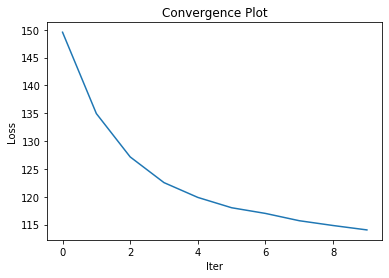

In [107]:
losses = model.train(
    targetSeries=rainfall_series[:num_train], 
    sequenceLength=500,
    numIterations=10,
    optimizer=Adam(
        ExponentialDecay(
            0.01, 50, 0.9
        )
    )
)

plt.plot(losses)
plt.title('Convergence Plot')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.show()

## Forecasting Training Data

In [108]:
output_data = rainfall_series[1: num_train]
pred_outputs = model.predict(rainfall_series[:num_train - 1])

print(pred_outputs.shape, output_data.shape)

(15885,) (15885,)


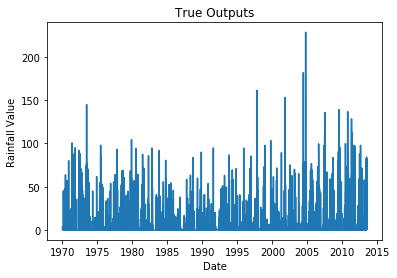

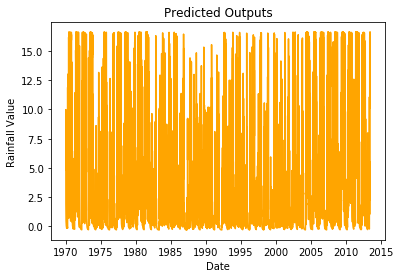

In [109]:
plt.plot(date_series[1: num_train], output_data)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('True Outputs')
plt.show()

plt.plot(date_series[1: num_train], pred_outputs, color='orange')
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('Predicted Outputs')
plt.show()

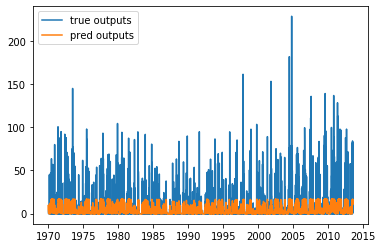

In [110]:
plt.plot(date_series[1: num_train], output_data, label='true outputs')
plt.plot(date_series[1: num_train], pred_outputs, label='pred outputs')
plt.legend()
plt.show()

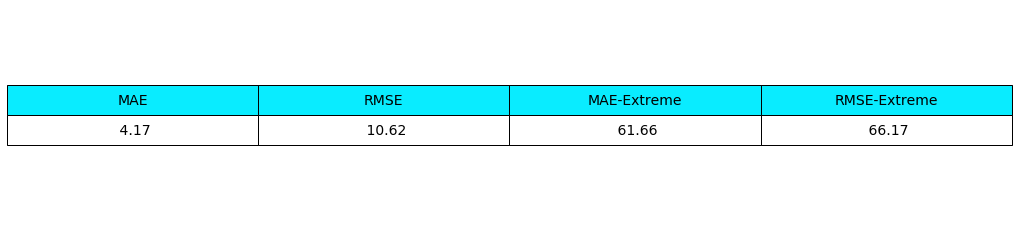

In [111]:
Plot.plotTable(
    ['MAE', 'RMSE', 'MAE-Extreme', 'RMSE-Extreme'],
    'top',
    np.array([[
        Metric.mae(pred_outputs, output_data), 
        Metric.rmse(pred_outputs, output_data),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.mae),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.rmse)
    ]])
)

## Forecasting Test Data

In [112]:
output_data = rainfall_series[num_train + 1:]
pred_outputs = model.predict(rainfall_series[num_train: n - 1])

print(pred_outputs.shape, output_data.shape)

(1765,) (1765,)


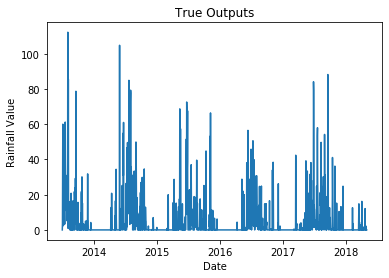

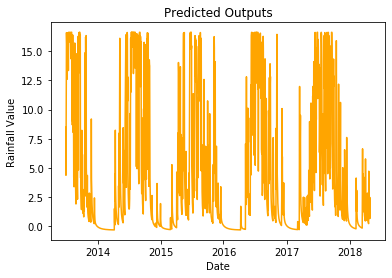

In [113]:
plt.plot(date_series[num_train + 1:], output_data)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('True Outputs')
plt.show()

plt.plot(date_series[num_train + 1:], pred_outputs, color='orange')
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('Predicted Outputs')
plt.show()

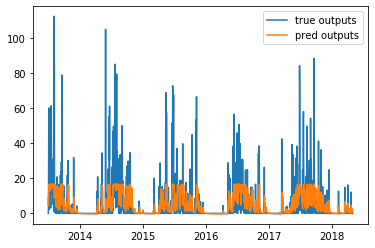

In [114]:
plt.plot(date_series[num_train + 1:], output_data, label='true outputs')
plt.plot(date_series[num_train + 1:], pred_outputs, label='pred outputs')
plt.legend()
plt.show()

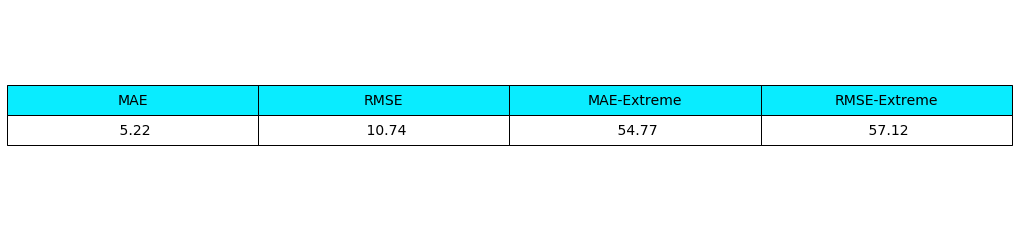

In [115]:
Plot.plotTable(
    ['MAE', 'RMSE', 'MAE-Extreme', 'RMSE-Extreme'],
    'top',
    np.array([[
        Metric.mae(pred_outputs, output_data), 
        Metric.rmse(pred_outputs, output_data),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.mae),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.rmse)
    ]])
)

# GMM-HMM Forecasting Algorithm

In [143]:
from ts.model import GmmHmmForecast

d = 10
model = GmmHmmForecast(
    numStates=2,
    numMixtureComp=2,
    dimension=1,
    d=d,
    numIterations=9,
    threshold=0.0
)

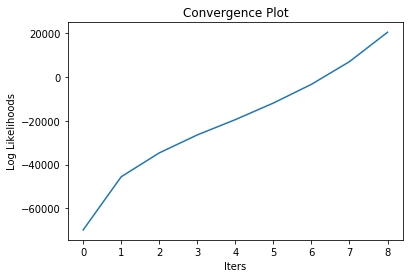

In [140]:
log_likelihoods = model.train([rainfall_series[:num_train, np.newaxis]])

plt.plot(log_likelihoods)
plt.xlabel('Iters')
plt.ylabel('Log Likelihoods')
plt.title('Convergence Plot')
plt.show()

## Forecasting Training Data

In [146]:
output_data = rainfall_series[d + 1: num_train]
pred_outputs = np.squeeze(model.predict(
    rainfall_series[:num_train - 1, np.newaxis],
    [np.linspace(
        rainfall_series[1: num_train].min(),
        rainfall_series[1: num_train].max(),
        10
    )]
), axis=1)

print(pred_outputs.shape, output_data.shape)

(15875,) (15875,)


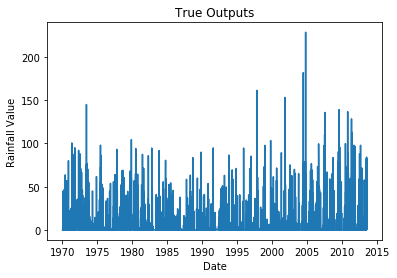

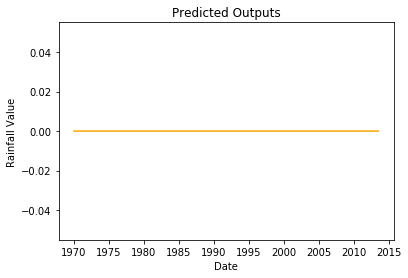

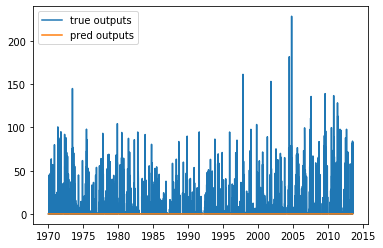

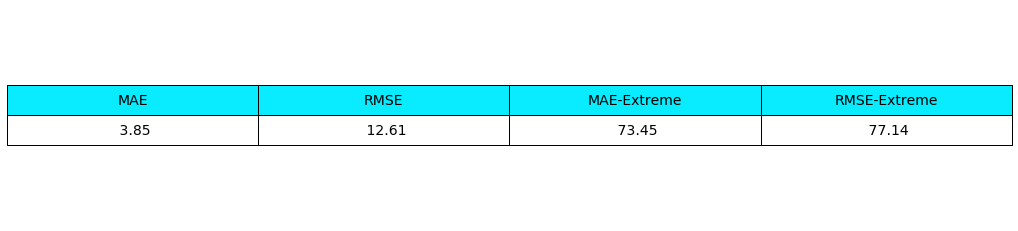

In [147]:
plt.plot(date_series[d + 1: num_train], output_data)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('True Outputs')
plt.show()

plt.plot(date_series[d + 1: num_train], pred_outputs, color='orange')
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('Predicted Outputs')
plt.show()

plt.plot(date_series[d + 1: num_train], output_data, label='true outputs')
plt.plot(date_series[d + 1: num_train], pred_outputs, label='pred outputs')
plt.legend()
plt.show()

Plot.plotTable(
    ['MAE', 'RMSE', 'MAE-Extreme', 'RMSE-Extreme'],
    'top',
    np.array([[
        Metric.mae(pred_outputs, output_data), 
        Metric.rmse(pred_outputs, output_data),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.mae),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.rmse)
    ]])
)

## Forecasting Test Data

In [153]:
output_data = rainfall_series[d + num_train + 1:]
pred_outputs = np.squeeze(model.predict(
    rainfall_series[num_train: n - 1, np.newaxis],
    [np.linspace(
        rainfall_series[1: num_train].min(),
        rainfall_series[1: num_train].max(),
        3
    )]
), axis=1)

print(pred_outputs.shape, output_data.shape)

(1755,) (1755,)


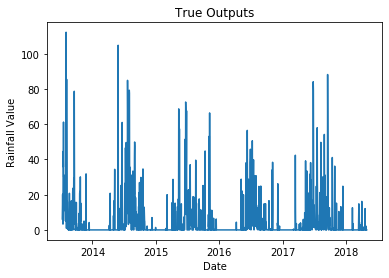

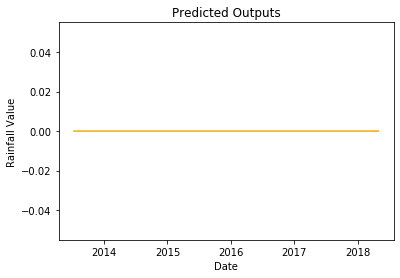

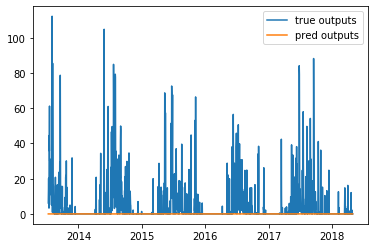

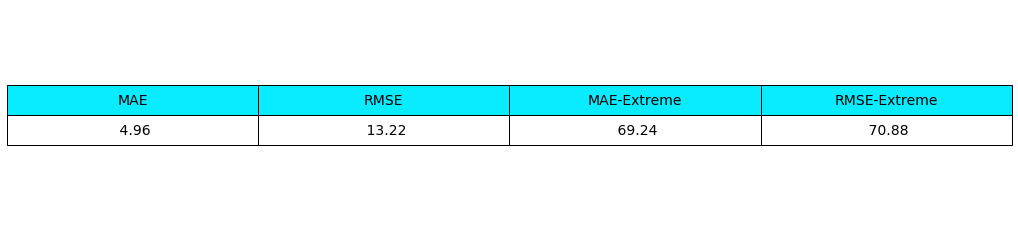

In [154]:
plt.plot(date_series[d + num_train + 1:], output_data)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('True Outputs')
plt.show()

plt.plot(date_series[d + num_train + 1:], pred_outputs, color='orange')
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('Predicted Outputs')
plt.show()

plt.plot(date_series[d + num_train + 1:], output_data, label='true outputs')
plt.plot(date_series[d + num_train + 1:], pred_outputs, label='pred outputs')
plt.legend()
plt.show()

Plot.plotTable(
    ['MAE', 'RMSE', 'MAE-Extreme', 'RMSE-Extreme'],
    'top',
    np.array([[
        Metric.mae(pred_outputs, output_data), 
        Metric.rmse(pred_outputs, output_data),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.mae),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.rmse)
    ]])
)

# GMM-HMM Likelihood Similarity

In [155]:
from ts.model import GmmHmmLikelihoodSimilarity

model = GmmHmmLikelihoodSimilarity(
    numStates=2,
    numMixtureComp=2,
    dimension=1,
    numIterations=9,
    threshold=0.0
)

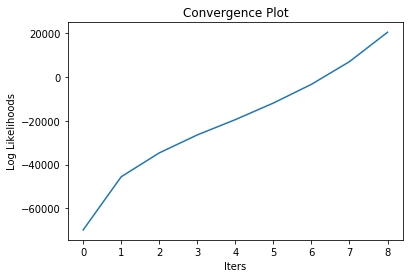

In [156]:
log_likelihoods = model.train([rainfall_series[:num_train, np.newaxis]])

plt.plot(log_likelihoods)
plt.xlabel('Iters')
plt.ylabel('Log Likelihoods')
plt.title('Convergence Plot')
plt.show()

## Forecasting Training Data

In [157]:
output_data = rainfall_series[1: num_train]
pred_outputs = np.squeeze(model.predict(
    rainfall_series[:num_train - 1, np.newaxis]
), axis=1)

print(pred_outputs.shape, output_data.shape)

(15885,) (15885,)


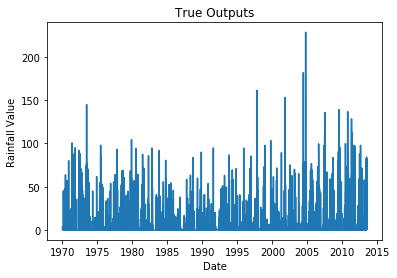

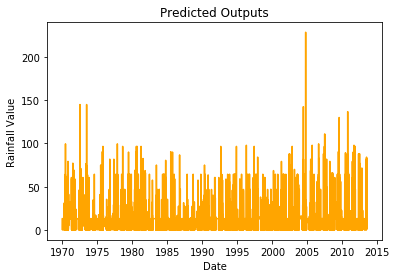

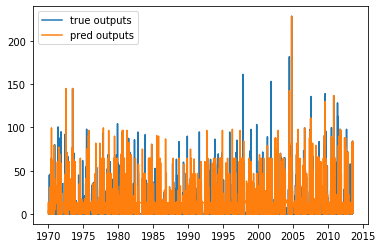

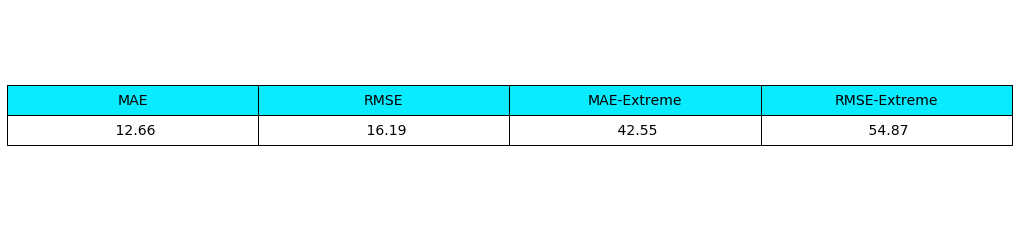

In [158]:
plt.plot(date_series[1: num_train], output_data)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('True Outputs')
plt.show()

plt.plot(date_series[1: num_train], pred_outputs, color='orange')
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('Predicted Outputs')
plt.show()

plt.plot(date_series[1: num_train], output_data, label='true outputs')
plt.plot(date_series[1: num_train], pred_outputs, label='pred outputs')
plt.legend()
plt.show()

Plot.plotTable(
    ['MAE', 'RMSE', 'MAE-Extreme', 'RMSE-Extreme'],
    'top',
    np.array([[
        Metric.mae(pred_outputs, output_data), 
        Metric.rmse(pred_outputs, output_data),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.mae),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.rmse)
    ]])
)

## Forecasting Test Data

In [159]:
output_data = rainfall_series[num_train + 1:]
pred_outputs = np.squeeze(model.predict(
    rainfall_series[num_train: n - 1, np.newaxis]
), axis=1)

print(pred_outputs.shape, output_data.shape)

(1765,) (1765,)


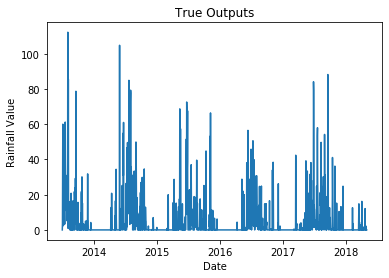

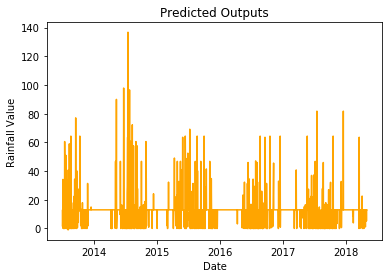

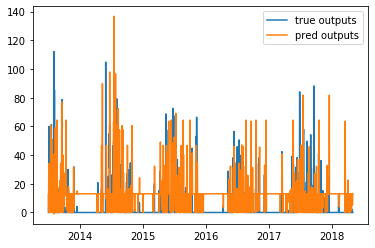

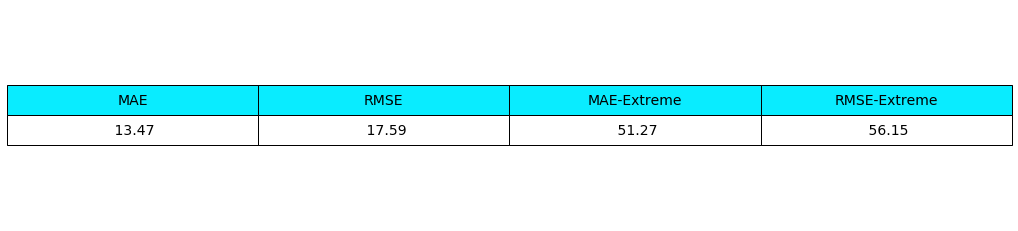

In [161]:
plt.plot(date_series[num_train + 1:], output_data)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('True Outputs')
plt.show()

plt.plot(date_series[num_train + 1:], pred_outputs, color='orange')
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('Predicted Outputs')
plt.show()

plt.plot(date_series[num_train + 1:], output_data, label='true outputs')
plt.plot(date_series[num_train + 1:], pred_outputs, label='pred outputs')
plt.legend()
plt.show()

Plot.plotTable(
    ['MAE', 'RMSE', 'MAE-Extreme', 'RMSE-Extreme'],
    'top',
    np.array([[
        Metric.mae(pred_outputs, output_data), 
        Metric.rmse(pred_outputs, output_data),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.mae),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.rmse)
    ]])
)

# LSTM

In [175]:
from tensorflow.keras.layers import LSTM, TimeDistributed
from ts.model import RecurrentForecast

model = RecurrentForecast(
    forecastHorizon=1,
    layerList=[
        LSTM(16, activation='tanh', return_sequences=True),
        LSTM(32, activation='tanh', return_sequences=True),
        LSTM(16, activation='tanh', return_sequences=True),
        TimeDistributed(Dense(1, activation='linear'))
    ]
)

seq_length = 200
model.train(
    Utility.breakSeq(rainfall_series[:num_train, np.newaxis], seq_length),
    numIterations=10,
    optimizer=Adam(
        ExponentialDecay(
            0.01, 50, 0.98
        )
    )
)

Epoch 1/20
80/80 [==============================] - 9s 119ms/step - loss: 141.1082
Epoch 2/20
80/80 [==============================] - 9s 115ms/step - loss: 124.3440
Epoch 3/20
80/80 [==============================] - 11s 139ms/step - loss: 118.3979
Epoch 4/20
80/80 [==============================] - 12s 149ms/step - loss: 114.8209
Epoch 5/20
80/80 [==============================] - 10s 131ms/step - loss: 112.7846
Epoch 6/20
80/80 [==============================] - 10s 125ms/step - loss: 110.8078
Epoch 7/20
80/80 [==============================] - 10s 125ms/step - loss: 110.2596
Epoch 8/20
80/80 [==============================] - 11s 137ms/step - loss: 110.0026
Epoch 9/20
80/80 [==============================] - 10s 121ms/step - loss: 109.4015
Epoch 10/20
80/80 [==============================] - 9s 115ms/step - loss: 108.0982
Epoch 11/20
 6/80 [=>............................] - ETA: 7s - loss: 105.9564

KeyboardInterrupt: 

## Forecasting Training Data

(15885,) (15885,)


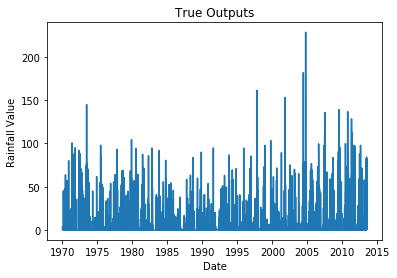

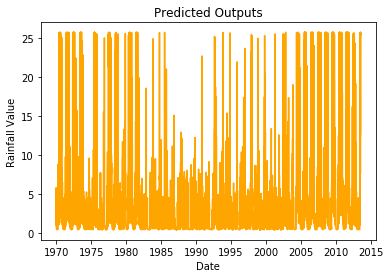

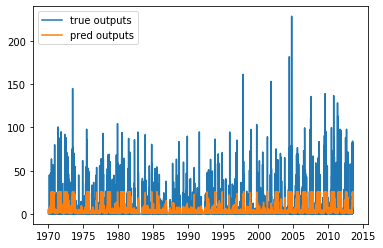

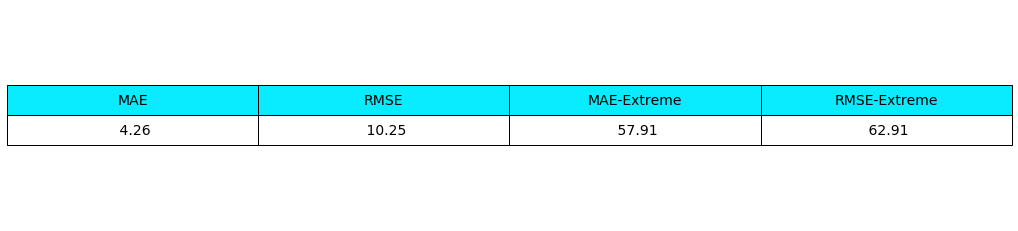

In [176]:
output_data = rainfall_series[1: num_train]
pred_outputs = np.squeeze(model.predict(
    rainfall_series[:num_train - 1, np.newaxis]
), axis=1)

print(pred_outputs.shape, output_data.shape)

plt.plot(date_series[1: num_train], output_data)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('True Outputs')
plt.show()

plt.plot(date_series[1: num_train], pred_outputs, color='orange')
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('Predicted Outputs')
plt.show()

plt.plot(date_series[1: num_train], output_data, label='true outputs')
plt.plot(date_series[1: num_train], pred_outputs, label='pred outputs')
plt.legend()
plt.show()

Plot.plotTable(
    ['MAE', 'RMSE', 'MAE-Extreme', 'RMSE-Extreme'],
    'top',
    np.array([[
        Metric.mae(pred_outputs, output_data), 
        Metric.rmse(pred_outputs, output_data),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.mae),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.rmse)
    ]])
)

## Forecasting Test Data

(1765,) (1765,)


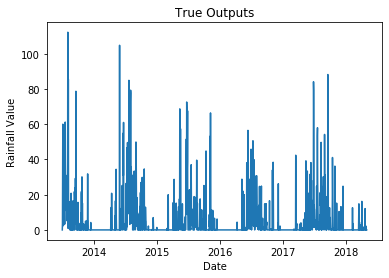

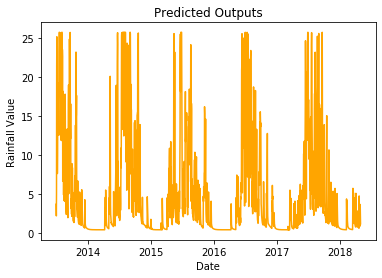

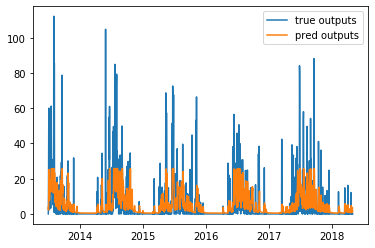

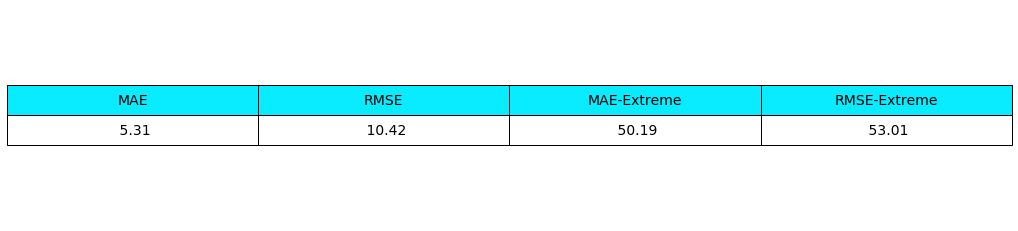

In [177]:
output_data = rainfall_series[num_train + 1:]
pred_outputs = np.squeeze(model.predict(
    rainfall_series[num_train: n - 1, np.newaxis]
), axis=1)

print(pred_outputs.shape, output_data.shape)

plt.plot(date_series[num_train + 1:], output_data)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('True Outputs')
plt.show()

plt.plot(date_series[num_train + 1:], pred_outputs, color='orange')
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('Predicted Outputs')
plt.show()

plt.plot(date_series[num_train + 1:], output_data, label='true outputs')
plt.plot(date_series[num_train + 1:], pred_outputs, label='pred outputs')
plt.legend()
plt.show()

Plot.plotTable(
    ['MAE', 'RMSE', 'MAE-Extreme', 'RMSE-Extreme'],
    'top',
    np.array([[
        Metric.mae(pred_outputs, output_data), 
        Metric.rmse(pred_outputs, output_data),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.mae),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.rmse)
    ]])
)

# LSTM

In [178]:
from tensorflow.keras.layers import GRU
from ts.model import RecurrentForecast

model = RecurrentForecast(
    forecastHorizon=1,
    layerList=[
        GRU(16, activation='tanh', return_sequences=True),
        GRU(32, activation='tanh', return_sequences=True),
        GRU(16, activation='tanh', return_sequences=True),
        TimeDistributed(Dense(1, activation='linear'))
    ]
)

seq_length = 500
model.train(
    Utility.breakSeq(rainfall_series[:num_train, np.newaxis], seq_length),
    numIterations=10,
    optimizer=Adam(
        ExponentialDecay(
            0.01, 50, 0.9
        )
    )
)

Epoch 1/10
32/32 [==============================] - 11s 329ms/step - loss: 134.2547
Epoch 2/10
32/32 [==============================] - 11s 343ms/step - loss: 126.1950
Epoch 3/10
32/32 [==============================] - 13s 409ms/step - loss: 121.4728
Epoch 4/10
32/32 [==============================] - 12s 371ms/step - loss: 118.4547
Epoch 5/10
32/32 [==============================] - 14s 427ms/step - loss: 116.4427
Epoch 6/10
32/32 [==============================] - 11s 348ms/step - loss: 115.0590
Epoch 7/10
32/32 [==============================] - 11s 341ms/step - loss: 114.1513
Epoch 8/10
32/32 [==============================] - 11s 337ms/step - loss: 113.0337
Epoch 9/10
32/32 [==============================] - 11s 339ms/step - loss: 111.7236
Epoch 10/10
32/32 [==============================] - 11s 343ms/step - loss: 111.0319


[134.25474220514297,
 126.19500571489334,
 121.47284525632858,
 118.45468318462372,
 116.44274234771729,
 115.05899351835251,
 114.15128481388092,
 113.03365623950958,
 111.72355049848557,
 111.031942486763]

In [180]:
output_data.shape

(15885,)

## Forecasting Training Data

(15885,) (15885,)


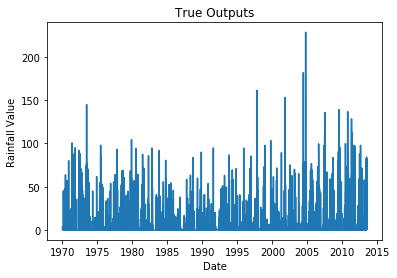

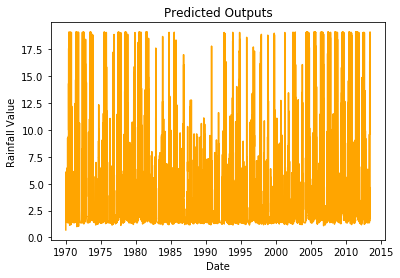

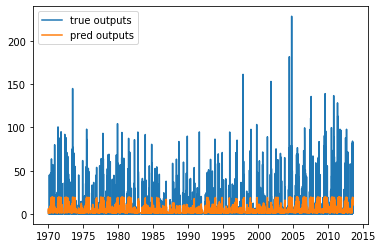

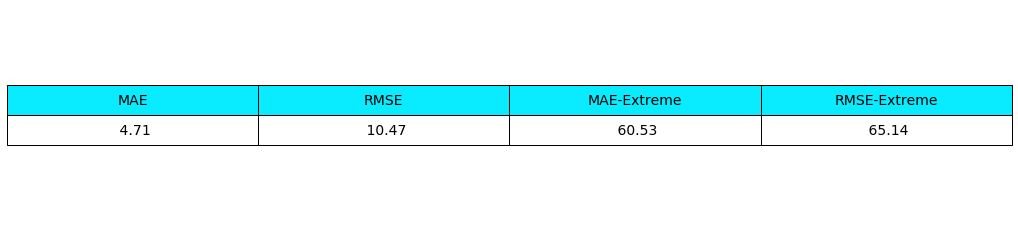

In [183]:
output_data = rainfall_series[1: num_train]
pred_outputs = np.squeeze(model.predict(
    rainfall_series[:num_train - 1, np.newaxis]
), axis=1)

print(pred_outputs.shape, output_data.shape)

plt.plot(date_series[1: num_train], output_data)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('True Outputs')
plt.show()

plt.plot(date_series[1: num_train], pred_outputs, color='orange')
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('Predicted Outputs')
plt.show()

plt.plot(date_series[1: num_train], output_data, label='true outputs')
plt.plot(date_series[1: num_train], pred_outputs, label='pred outputs')
plt.legend()
plt.show()

Plot.plotTable(
    ['MAE', 'RMSE', 'MAE-Extreme', 'RMSE-Extreme'],
    'top',
    np.array([[
        Metric.mae(pred_outputs, output_data), 
        Metric.rmse(pred_outputs, output_data),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.mae),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.rmse)
    ]])
)

## Forecasting Test Data

(1765,) (1765,)


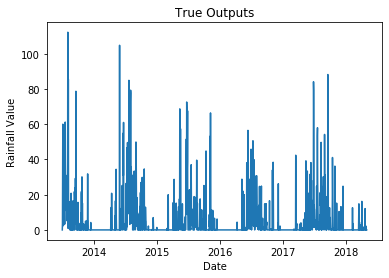

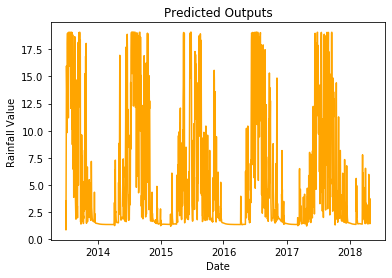

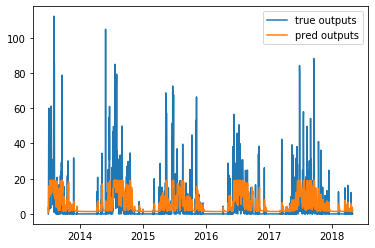

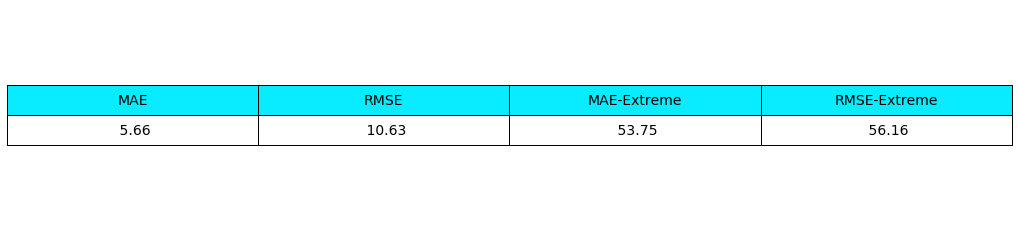

In [184]:
output_data = rainfall_series[num_train + 1:]
pred_outputs = np.squeeze(model.predict(
    rainfall_series[num_train: n - 1, np.newaxis]
), axis=1)

print(pred_outputs.shape, output_data.shape)

plt.plot(date_series[num_train + 1:], output_data)
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('True Outputs')
plt.show()

plt.plot(date_series[num_train + 1:], pred_outputs, color='orange')
plt.xlabel('Date')
plt.ylabel('Rainfall Value')
plt.title('Predicted Outputs')
plt.show()

plt.plot(date_series[num_train + 1:], output_data, label='true outputs')
plt.plot(date_series[num_train + 1:], pred_outputs, label='pred outputs')
plt.legend()
plt.show()

Plot.plotTable(
    ['MAE', 'RMSE', 'MAE-Extreme', 'RMSE-Extreme'],
    'top',
    np.array([[
        Metric.mae(pred_outputs, output_data), 
        Metric.rmse(pred_outputs, output_data),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.mae),
        Metric.errorOnExtremes(pred_outputs, output_data, threshold, Metric.rmse)
    ]])
)